# Demo of VAE for anomaly detection of diverse sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace

In [3]:
from demo import *
device

device(type='cuda', index=0)

In [4]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [5]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 6.172
Epoch: 293


In [6]:
params = model.demo()

Input size: torch.Size([1, 14, 512])
Encoded size: torch.Size([1, 1024, 4])
Latent size: torch.Size([1, 50, 1])
Decoded (output) size: torch.Size([1, 14, 512])


In [7]:
X, E, L, D = [param.cpu().detach().numpy() for param in params]
MSE = np.power((X - D), 2).sum() / 2
print(f"MSE of random data = {MSE:.3f}")

MSE of random data = 652.977


In [8]:
X[:, :4, :4]

array([[[0.6459665 , 0.22374074, 0.52047163, 0.9864556 ],
        [0.6086841 , 0.9698631 , 0.40239358, 0.67587596],
        [0.5372259 , 0.5510935 , 0.5808073 , 0.8755192 ],
        [0.9044502 , 0.49064955, 0.6976321 , 0.06048599]]], dtype=float32)

In [9]:
D[:, :4, :4]

array([[[ 0.33235973,  0.2875989 ,  0.31421584,  0.36693963],
        [ 0.23836832, -0.00981139, -0.06727779, -0.07092988],
        [ 0.6996496 ,  0.7077862 ,  0.72754145,  0.7373017 ],
        [ 0.3524381 ,  0.3773844 ,  0.49124527,  0.6378786 ]]],
      dtype=float32)

Next we need to load the datasets of sensors readings.

In [10]:
data_path = Path(f'data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [11]:
print(len(train_dl), len(val_dl), len(test_dl))

28 7 1100


Let's get some random samples from the dataset for examples and generate new versions.

In [12]:
data, targets = get_random_samples(test_dl)

In [13]:
classes = list_target_classes(test_dl)

0 = fail
1 = norm


In [14]:
targets = targets.cpu().numpy()
targets

array([0, 0, 1, ..., 1, 0, 0])

In [15]:
y_true = targets == 0
y_true.sum() / y_true.size

0.6654545454545454

In [16]:
print('normals = ', targets.sum())

normals =  368


In [17]:
print('failures = ', len(targets) - targets.sum())

failures =  732


In [18]:
criterion = VAE1DLoss()
criterion = criterion.to(device)

In [19]:
model.eval()
with torch.no_grad():
    # Generate
    data = data.to(device)
    gen_data, mu, logvar = model(data)
    loss, loss_desc = criterion(gen_data, data, mu, logvar, reduce=False)
    

In [20]:
gen_err = -loss_desc['logp']
gen_err

tensor([111.9767,   4.7205,   5.4780,  ...,   0.7387, 111.1759, 106.1873],
       device='cuda:0')

[[-0.08240902 -0.04938802 -0.04444626  0.04240939 -0.0286864 ]
 [ 0.02595676 -0.08698311 -0.03718611 -0.08600208 -0.0561974 ]
 [-0.4712329  -0.24144098 -0.27823097 -0.17862031 -0.19126622]
 [-0.12770307 -0.17285085 -0.21438435 -0.05525964 -0.08942223]
 [-0.10659608 -0.14341149 -0.1113736  -0.0817442  -0.05213144]]
MSE = 111.97673034667969


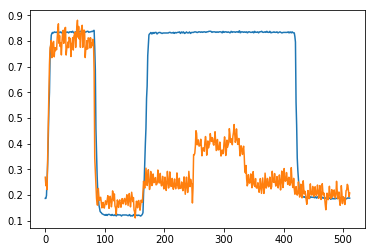

In [21]:
idx = 0
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

[[-0.06567065 -0.03160676  0.00624555  0.03201348  0.03093433]
 [-0.00587006 -0.04803919 -0.01050714 -0.03889262 -0.03260443]
 [-0.29221153 -0.14907148 -0.16446981 -0.10091981 -0.12159541]
 [-0.05141941 -0.02973509 -0.05715403  0.03540289  0.0032956 ]
 [-0.04303628 -0.06454238 -0.0906553  -0.05360758 -0.04467713]]
MSE = 4.720505714416504


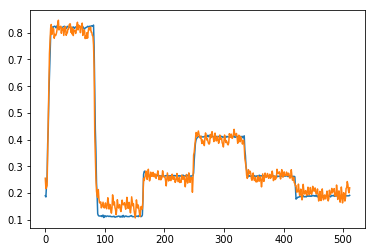

In [22]:
idx = 1
sample = data[idx, :, :].cpu().numpy()
gen_sample = gen_data[idx, :, :].cpu().numpy()
plt.plot(sample[0, :])
plt.plot(gen_sample[0, :])
print(sample[:5, :5] - gen_sample[:5, :5])
print(f"MSE = {np.power((sample - gen_sample), 2).sum() / 2}")

In [23]:
err = np.zeros(targets.shape)
for i, target in enumerate(targets):
    err[i] = -loss_desc['logp'][i]
    print(f"Target = {target}, MSE = {err[i]:.3f}")
    if i > 10:
        break

Target = 0, MSE = 111.977
Target = 0, MSE = 4.721
Target = 1, MSE = 5.478
Target = 0, MSE = 3.435
Target = 1, MSE = 1.419
Target = 0, MSE = 108.712
Target = 1, MSE = 1.785
Target = 1, MSE = 0.653
Target = 1, MSE = 19.111
Target = 0, MSE = 9.508
Target = 0, MSE = 109.615
Target = 0, MSE = 4.629


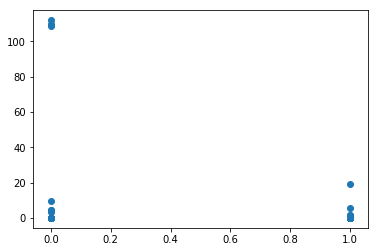

In [24]:
plt.scatter(targets, err)

Show the data plots.

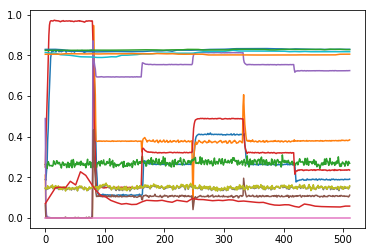

In [25]:
show_plot(sample)

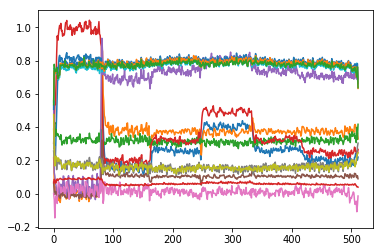

In [26]:
show_plot(gen_sample)

Let's score the success of the recreation and look for outliers.

In [27]:
scores = score(test_dl, model, criterion)

100%|██████████| 1100/1100 [00:07<00:00, 153.44it/s]


In [28]:
test_means = pd.DataFrame()
for (name, cls), item in scores.items():
    test_means.loc[name, cls] = np.array(item).mean()

print("###################### TEST MEANS #####################")
print(test_means)

###################### TEST MEANS #####################
              fail        norm
loss   2845.764728  335.062492
KL     2802.365372  322.847039
error    43.399359   12.215453


In [29]:
val_means = pd.DataFrame()
for (name, cls), item in score(val_dl, model, criterion).items():
    val_means.loc[name, cls] = np.array(item).mean()

print("###################### VAL MEANS #####################")
print(val_means)

100%|██████████| 7/7 [00:01<00:00,  5.51it/s]

###################### VAL MEANS #####################
             norm
loss   346.039422
KL     333.424469
error   12.614954


In [30]:
train_means = pd.DataFrame()
for (name, cls), item in score(train_dl, model, criterion).items():
    train_means.loc[name, cls] = np.array(item).mean()

print("###################### TRAIN MEANS #####################")
print(train_means)

100%|██████████| 28/28 [00:04<00:00,  6.72it/s]

###################### TRAIN MEANS #####################
             norm
loss   466.001099
KL     453.726152
error   12.274948


Let's calculate AUC to judge performance.

In [31]:
scores.keys()

dict_keys([('loss', 'fail'), ('loss', 'norm'), ('KL', 'fail'), ('KL', 'norm'), ('error', 'fail'), ('error', 'norm')])

In [32]:
print(len(scores[('error', 'norm')]), len(scores[('error', 'fail')]))

368 732


In [90]:
# simple definition of the threshold as mean between sets
threshold = (np.mean(scores['error', 'fail']) +
             np.mean(scores['error', 'norm'])) / 2
print('mean threshold:', threshold)
# maximum 95% percentile of normal as threshold
threshold = np.percentile(scores['error', 'norm'], 95)
print('95th percentile threshold:', threshold)

mean threshold: 27.80740566768109
95th percentile threshold: 52.35094413757317


In [91]:
t_scores = scores.copy()
t_scores[('error', 'fail')] = (t_scores[('error', 'fail')] > threshold)
t_scores[('error', 'norm')] = (t_scores[('error', 'norm')] > threshold)
t_score = []
t_score.extend(t_scores[('error', 'fail')])
t_score.extend(t_scores[('error', 'norm')])

In [92]:
t_corr = t_score == y_true
t_corr.sum() / len(t_corr)

0.42272727272727273

In [93]:
auc_scores = auc_score(test_dl, t_scores)
auc_scores

0.6449498099311001

In [94]:
np.mean(scores['error', 'norm'])

12.215452609097827

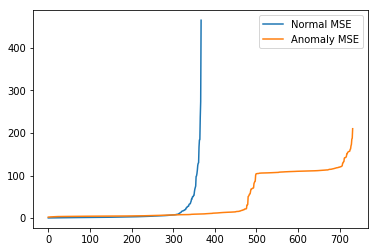

In [95]:
normaly = sorted(scores[('error', 'norm')])
anomaly = sorted(scores[('error', 'fail')])
plt.plot(normaly, label='Normal MSE')
plt.plot(anomaly, label='Anomaly MSE')
plt.legend()

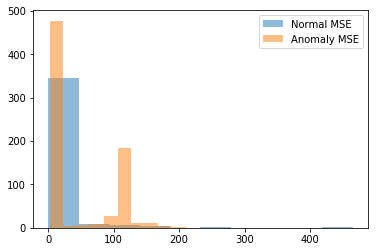

In [96]:
plt.hist(normaly, label='Normal MSE', alpha=0.5)
plt.hist(anomaly, label='Anomaly MSE', alpha=0.5)
plt.legend()

In [97]:
normalx = np.random.rand(len(normaly))
anomalx = np.random.rand(len(anomaly))

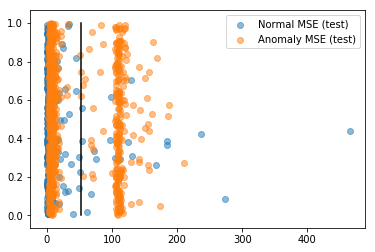

In [98]:
plt.scatter(normaly, normalx, label='Normal MSE (test)', alpha=0.5)
plt.scatter(anomaly, anomalx, label='Anomaly MSE (test)', alpha=0.5)
plt.plot([threshold, threshold], [0, 1], 'k-')
plt.legend()

Try fitting a normal distribution to the validation MSE to define a threshold.

In [42]:
val_scores = score(val_dl, model, criterion)

100%|██████████| 7/7 [00:01<00:00,  5.54it/s]


In [43]:
val_scores.keys()

dict_keys([('loss', 'norm'), ('KL', 'norm'), ('error', 'norm')])

[0.45210331678390503, 0.46253901720046997, 0.47381341457366943, 0.5370461344718933, 0.5406607985496521]
mean=12.61, stdev=37.02


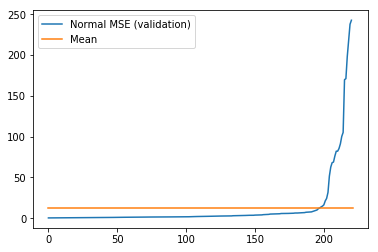

In [44]:
val_norm = sorted(val_scores[('error', 'norm')])
print(val_norm[:5])
mean = np.mean(val_norm)
std = np.std(val_norm)
print('mean={:.2f}, stdev={:.2f}'.format(mean, std))
plt.plot(val_norm, label= 'Normal MSE (validation)')
plt.plot([0, len(val_norm)], [mean, mean], label='Mean')
plt.legend()

Implement PCA to visualize the latent space.

In [107]:
latents, targets = compute_latent(test_dl, model)

100%|██████████| 1100/1100 [00:07<00:00, 151.79it/s]


In [108]:
from sklearn.decomposition import PCA

In [109]:
pca = PCA(n_components=2)

In [110]:
lat_pca = pca.fit_transform(latents)

In [111]:
lat_pca.shape

(1100, 2)

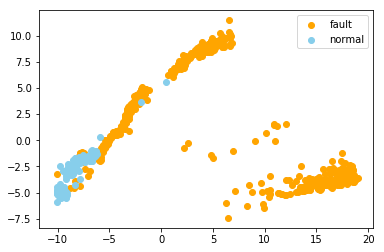

In [112]:
fail_mask = targets == 0
norm_mask = targets == 1
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [113]:
pca.explained_variance_ratio_

array([0.6775146 , 0.15461114], dtype=float32)

Cluster the latent space into kmeans clusters.

In [114]:
from sklearn.cluster import KMeans

In [119]:
kmeans = KMeans(3)

In [120]:
lat_k = kmeans.fit_transform(latents)

In [121]:
lat_k.shape

(1100, 3)

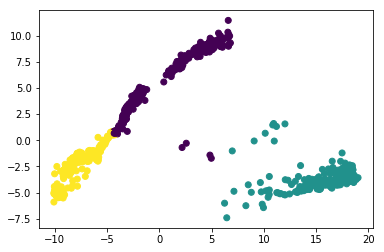

In [122]:
plt.scatter(lat_pca[:, 0], lat_pca[:, 1], c=kmeans.labels_)

Try adding the error terms to the latent features.

In [57]:
latents, kl, error, targets = compute_latent_and_loss(test_dl, model, criterion)

100%|██████████| 1100/1100 [00:07<00:00, 148.69it/s]


In [58]:
print(latents.shape, kl.shape, error.shape, targets.shape)

(1100, 50) (1100,) (1100,) (1100,)


In [59]:
features = np.hstack([latents, kl[:, None], error[:, None]])
features.shape

(1100, 52)

In [60]:
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(features)
lat_pca.shape

(1100, 2)

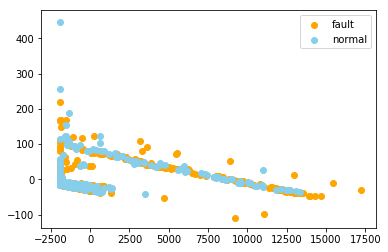

In [61]:
plt.scatter(lat_pca[fail_mask, 0], lat_pca[fail_mask, 1],
            c='orange', label='fault')
plt.scatter(lat_pca[norm_mask, 0], lat_pca[norm_mask, 1],
            c='skyblue', label='normal')
plt.legend()

In [62]:
pca.explained_variance_ratio_

array([9.99902819e-01, 9.30390067e-05])

Compare the pca plots for validation and training sets.

100%|██████████| 28/28 [00:04<00:00,  6.95it/s]


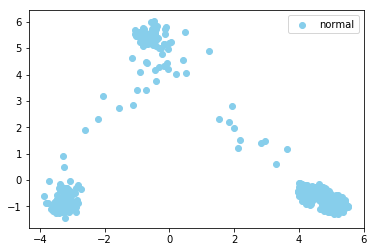

In [63]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


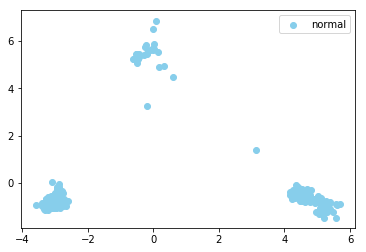

In [64]:
latents, targets = compute_latent(val_dl, model)
pca = PCA(n_components=2)
lat_pca = pca.fit_transform(latents)
plt.scatter(lat_pca[:, 0], lat_pca[:, 1],
            c='skyblue', label='normal')
plt.legend()

Combine the validation plot with the test plot to understand global structure.

In [124]:
latents, targets = compute_latent(train_dl, model)
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

100%|██████████| 28/28 [00:04<00:00,  6.98it/s]


In [125]:
latents, targets = compute_latent(val_dl, model)
val_pca = pca.transform(latents)

100%|██████████| 7/7 [00:01<00:00,  5.59it/s]


In [126]:
latents, targets = compute_latent(test_dl, model)
test_pca = pca.transform(latents)
fail_mask = targets == 0
norm_mask = targets == 1

100%|██████████| 1100/1100 [00:07<00:00, 155.31it/s]


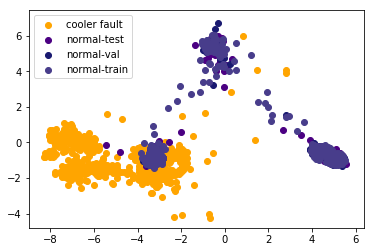

In [131]:
plt.scatter(test_pca[fail_mask, 0], test_pca[fail_mask, 1],
            c='orange', label=desc + ' fault')
plt.scatter(test_pca[norm_mask, 0], test_pca[norm_mask, 1],
            c='indigo', label='normal-test')
plt.scatter(val_pca[:, 0], val_pca[:, 1],
            c='midnightblue', label='normal-val')
plt.scatter(train_pca[:, 0], train_pca[:, 1],
            c='darkslateblue', label='normal-train')
plt.legend()